In [ ]:
import pandas as pd
import random
import itertools
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time
import numpy as np
from fairlearn.datasets import fetch_acs_health
import shap

from scipy.spatial.distance import cosine, euclidean
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import uniform, randint
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ParameterSampler, train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder, TargetEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.utils import class_weight
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, classification_report,  roc_auc_score

import tensorflow
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam
from xgboost import XGBRegressor, XGBClassifier #continuous values?


In [55]:
raw_data = pd.read_csv(r"C:\Users\odiee\OneDrive\Documents\24-25\Blok4\HCML\Project\Notebooks\ACSPUMS1.csv")

In [7]:
print(raw_data.head())
raw_data.isna().sum()

   PWGTP  RAC1P  SEX  MAR  HICOV  DIS NAICSP  NATIVITY  ENG  SCHL  AGEP  \
0     13      1    1    1      2    2     23         1    0    17    35   
1     17      2    1    5      2    2      N         1    0    12    43   
2      6      2    2    5      1    1   4853         1    0    18    58   
3     12      1    1    5      2    2      N         1    0    12    25   
4     14      1    1    5      1    2  611M1         1    0    16    21   

   PINCP  WKHP  Unnamed: 13  
0  63000    80          NaN  
1      0     0          NaN  
2  23100    20          NaN  
3      0     0          NaN  
4  17000    40          NaN  


PWGTP                 0
RAC1P                 0
SEX                   0
MAR                   0
HICOV                 0
DIS                   0
NAICSP                0
NATIVITY              0
ENG                   0
SCHL                  0
AGEP                  0
PINCP                 0
WKHP                  0
Unnamed: 13    15912393
dtype: int64

In [26]:
print("NAICSP dtype:", raw_data['NAICSP'].dtype)
print("Unique values (sample):", raw_data['NAICSP'].unique()[:10])


NAICSP dtype: object
Unique values (sample): ['23' '4853' '611M1' '562' '722Z' '6216' '4551' '721M' '5617Z' '516']


In [56]:
# filter out NaN column
raw_data = raw_data.drop(columns=['Unnamed: 13', 'PWGTP'], errors='ignore')

# preprocess NAICS
raw_data = raw_data[raw_data['NAICSP'] !='N']
raw_data = raw_data[raw_data['NAICSP'] !='999920']

In [57]:
# Check for '999920' as a string
print("'999920' in NAICSP?", '999920' in raw_data['NAICSP'].astype(str).values)

# Check for 999920 as an integer
print("999920 in NAICSP?", 999920 in raw_data['NAICSP'].values)

print("'N' in NAICSP?", 'N' in raw_data['NAICSP'].astype(str).values)


'999920' in NAICSP? False
999920 in NAICSP? False
'N' in NAICSP? False


In [9]:
print(raw_data.head())

   PWGTP  RAC1P  SEX  MAR  HICOV  DIS NAICSP  NATIVITY  ENG  SCHL  AGEP  \
0     13      1    1    1      2    2     23         1    0    17    35   
2      6      2    2    5      1    1   4853         1    0    18    58   
4     14      1    1    5      1    2  611M1         1    0    16    21   
5     24      1    1    2      2    2    562         1    0    12    45   
6      5      6    2    5      1    2  611M1         2    0    19    21   

   PINCP  WKHP  
0  63000    80  
2  23100    20  
4  17000    40  
5   7700    50  
6   2000    15  


### Pre-processing: subsampling data

In [58]:
raw_data['strata'] = raw_data[['DIS', 'NATIVITY','RAC1P','SEX']].astype(str).agg('_'.join, axis=1)

sample,_ = train_test_split(raw_data, 
                             train_size=500_000, 
                             stratify=raw_data['strata'], 
                             random_state=42)




In [59]:
len(sample)

500000

### Check for proportions

In [12]:
print(raw_data['DIS'].value_counts(normalize=True))
print(sample['DIS'].value_counts(normalize=True)) 

print(raw_data['NATIVITY'].value_counts(normalize=True))
print(sample['NATIVITY'].value_counts(normalize=True))

print(raw_data['SEX'].value_counts(normalize=True))
print(sample['SEX'].value_counts(normalize=True))

DIS
2    0.902688
1    0.097312
Name: proportion, dtype: float64
DIS
2    0.90269
1    0.09731
Name: proportion, dtype: float64
NATIVITY
1    0.85568
2    0.14432
Name: proportion, dtype: float64
NATIVITY
1    0.855684
2    0.144316
Name: proportion, dtype: float64
SEX
1    0.513447
2    0.486553
Name: proportion, dtype: float64
SEX
1    0.513446
2    0.486554
Name: proportion, dtype: float64


In [13]:
print(raw_data['RAC1P'].value_counts(normalize=True))
print(sample['RAC1P'].value_counts(normalize=True))


RAC1P
1    0.700567
2    0.086076
9    0.085107
6    0.063519
8    0.052143
3    0.008784
7    0.001699
5    0.001549
4    0.000556
Name: proportion, dtype: float64
RAC1P
1    0.700564
2    0.086076
9    0.085108
6    0.063520
8    0.052140
3    0.008786
7    0.001700
5    0.001548
4    0.000558
Name: proportion, dtype: float64


In [14]:
print(raw_data['HICOV'].value_counts(normalize=True))
print(sample['HICOV'].value_counts(normalize=True))

HICOV
1    0.910656
2    0.089344
Name: proportion, dtype: float64
HICOV
1    0.910806
2    0.089194
Name: proportion, dtype: float64


In [75]:
sample.drop('strata', axis=1, inplace=True)
print(sample.head())

         RAC1P  SEX  MAR  HICOV  DIS NAICSP  NATIVITY  ENG  SCHL  AGEP  PINCP  \
9934215      9    1    1      1    2  3399M         2    1     1    50  40000   
3410406      1    2    5      1    2   4571         1    0    19    20  21000   
3951811      1    1    3      1    2   6111         1    0    20    61  66700   
6442468      1    2    5      1    2   722Z         1    0    16    33  15000   
6233601      1    1    5      1    2   4411         1    0    16    27  65000   

         WKHP  
9934215    60  
3410406    30  
3951811    40  
6442468    30  
6233601    70  


In [76]:
numeric_cols = ['AGEP', 'WKHP']
categorical_cols = ['DIS', 'NATIVITY','NAICSP','SCHL', 'MAR', 'ENG', 'SEX',  'RAC1P'] 


In [77]:
insurance_data = sample.copy() # create new df for insurance predictions
income_data = sample.copy()

In [78]:
insurance_data.rename(columns={"HICOV": "target"}, inplace=True)

In [85]:
income_data.drop('HICOV', axis = 1, inplace=True)
income_data.rename(columns={"PINCP": "target"}, inplace=True)

In [86]:
print(insurance_data.columns)
print(income_data.columns)

Index(['RAC1P', 'SEX', 'MAR', 'target', 'DIS', 'NAICSP', 'NATIVITY', 'ENG',
       'SCHL', 'AGEP', 'PINCP', 'WKHP'],
      dtype='object')
Index(['RAC1P', 'SEX', 'MAR', 'DIS', 'NAICSP', 'NATIVITY', 'ENG', 'SCHL',
       'AGEP', 'target', 'WKHP'],
      dtype='object')


## Data analysis/visualization

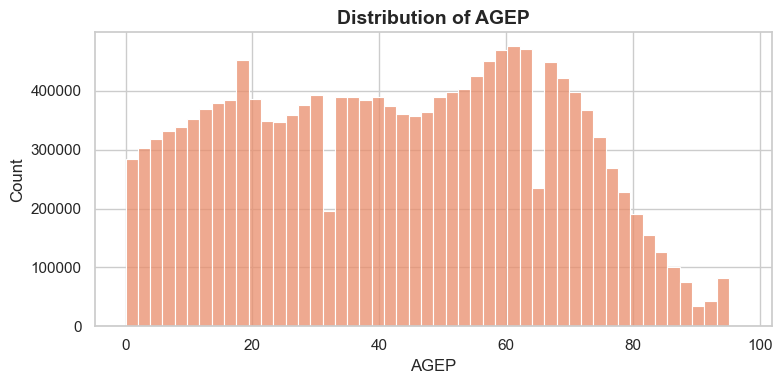

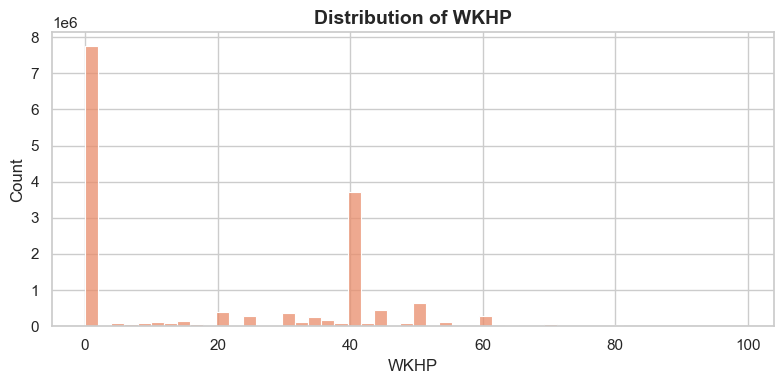

In [ ]:

sns.set_theme(style="whitegrid", palette="flare")

for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(insurance_data[col], bins=50, kde=False, color=sns.color_palette("flare")[0])
    plt.title(f'Distribution of {col}', fontsize=14, weight='bold')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()


### Categorical value visualization

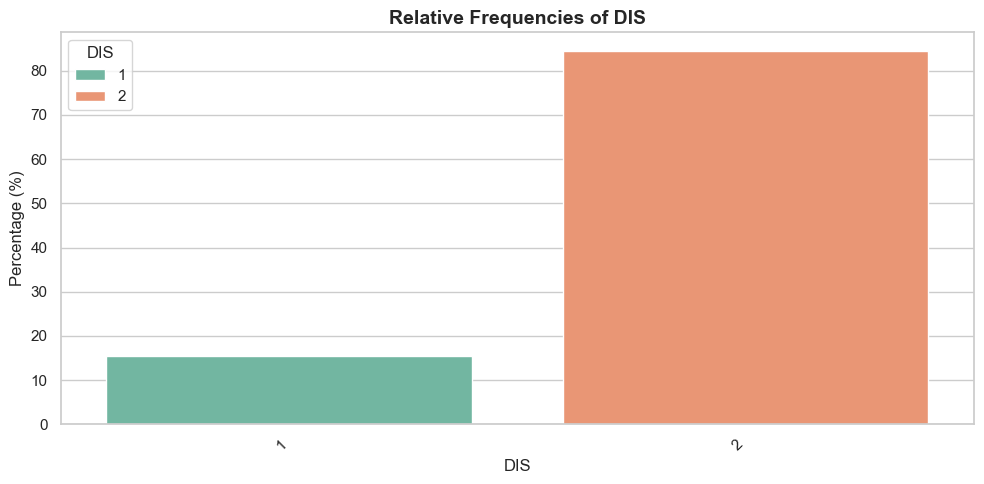

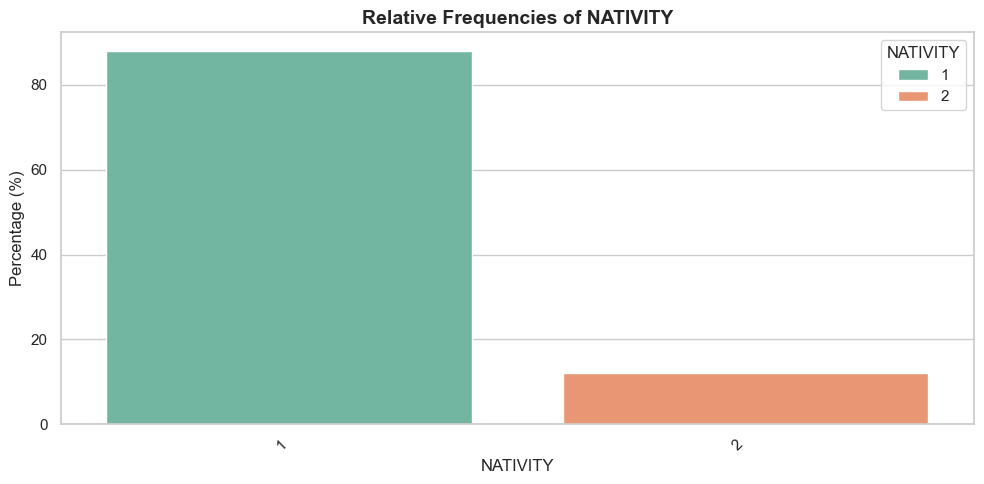

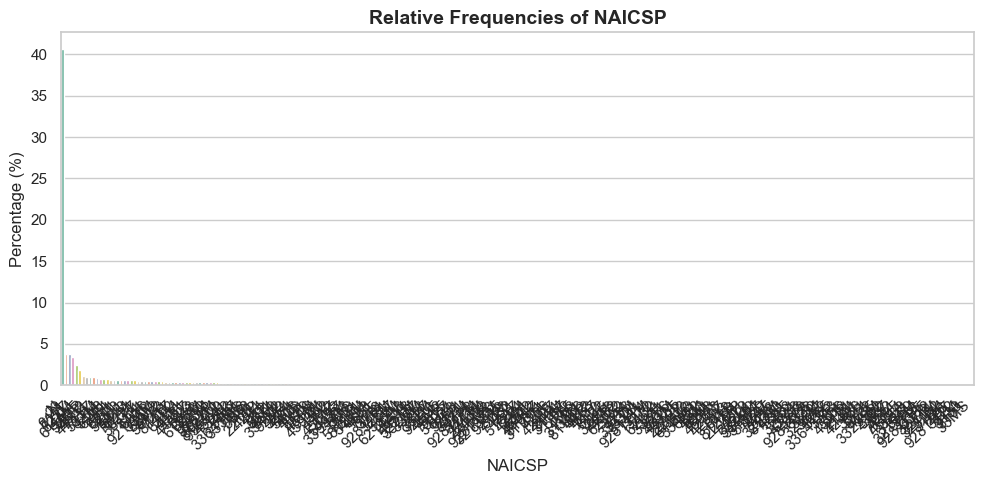

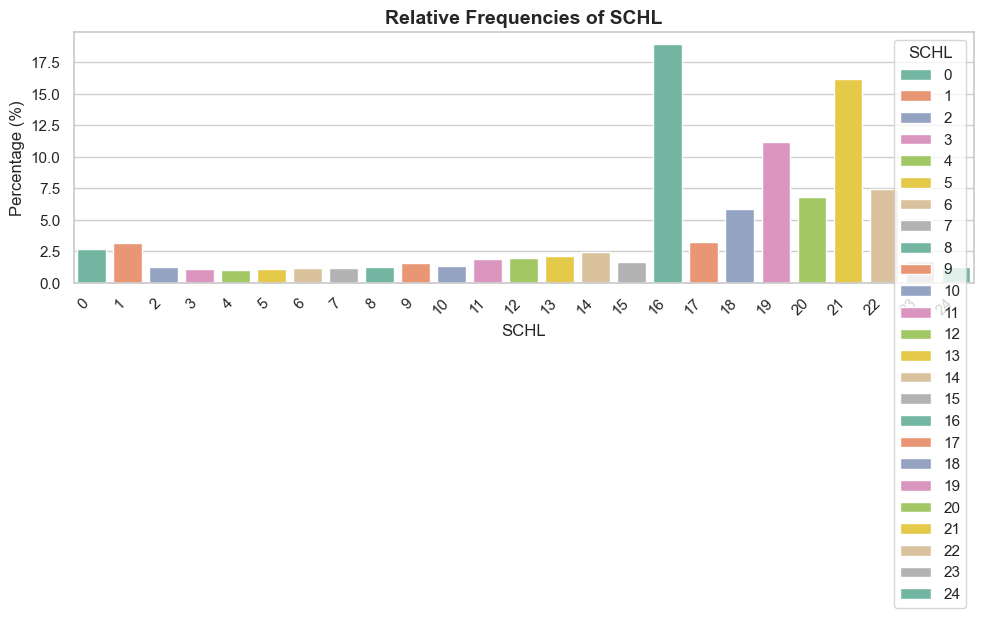

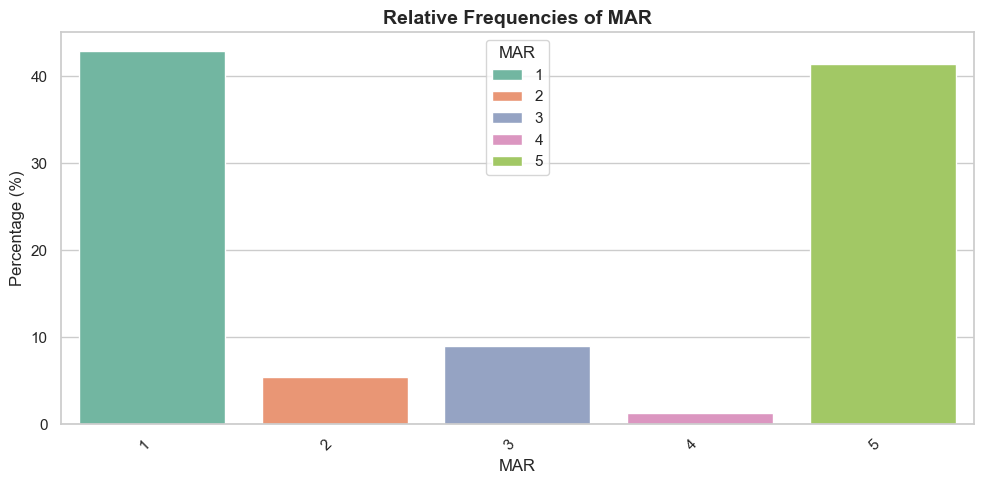

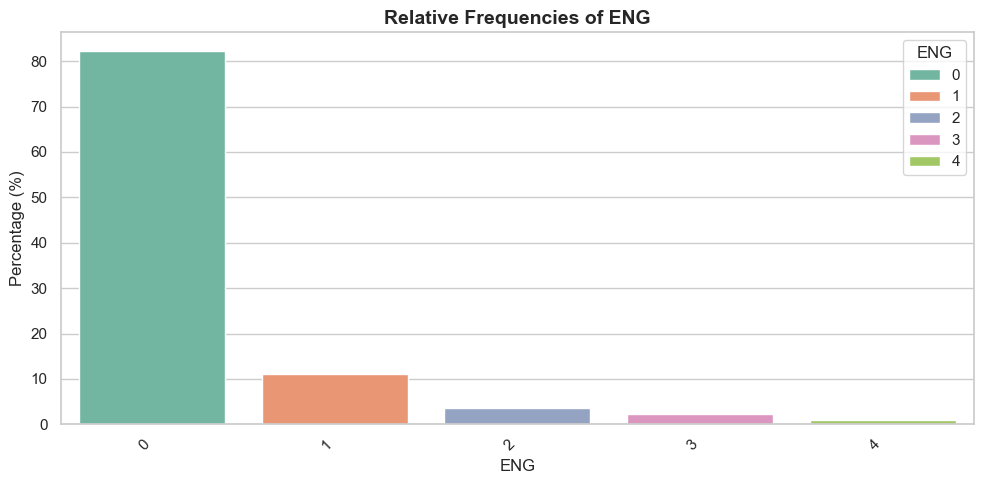

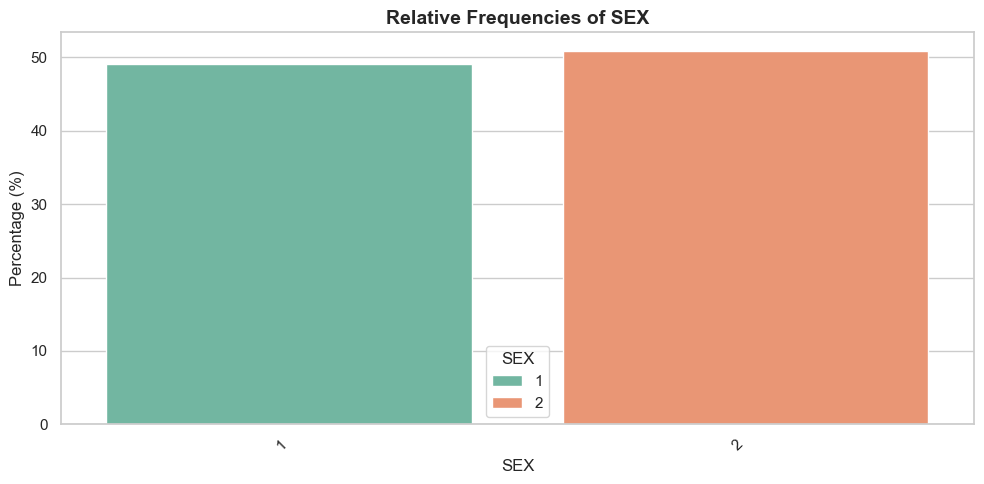

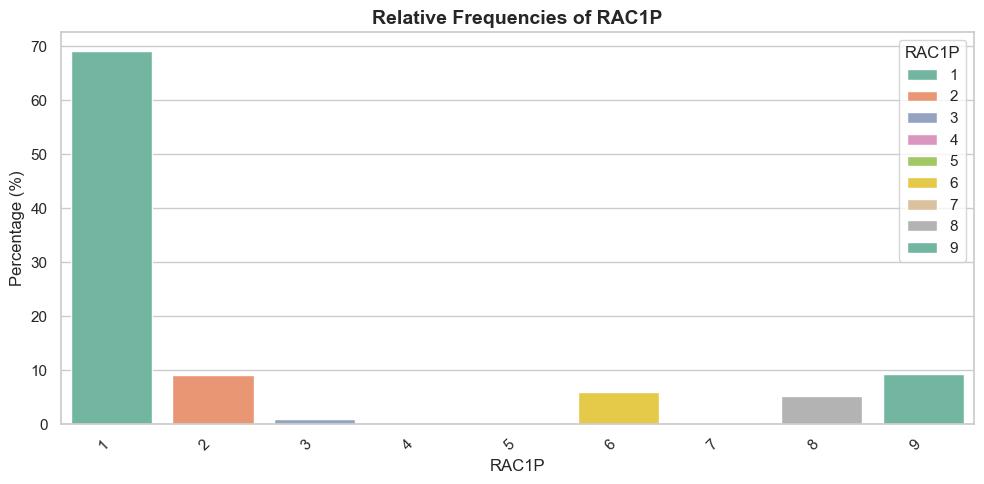

In [ ]:
sns.set_theme(style="whitegrid", palette="Set2")

limit_top_n = 30
columns_to_limit = ['OCCP', 'POBP'] 


for col in categorical_cols:
    plt.figure(figsize=(10, 5))

    # value counts normalized
    value_counts = insurance_data[col].value_counts(normalize=True) * 100
    
    if col in columns_to_limit:
        value_counts = value_counts.head(limit_top_n)

    plot_df = value_counts.reset_index()
    plot_df.columns = [col, 'percentage']

    sns.barplot(data=plot_df, x=col, y='percentage', hue=col, palette="Set2")
    
    plt.title(f'Relative Frequencies of {col}', fontsize=14, weight='bold')
    plt.xlabel(col)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

## Creating thresholds and splitting datasets

### Income dataset

In [87]:

def preprocess_income_data(df, threshold):
    df_copy = df.copy()
    df_copy['binary_target'] = (df_copy['target'] >= threshold).astype(int)
    y = df_copy['binary_target']
    X = df_copy.drop(columns=['target', 'binary_target'], errors='ignore')

    return X, y


preprocessor1 = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_cols)
    ],
    remainder='passthrough' 
)

threshold = 50000
X, y = preprocess_income_data(income_data, threshold)

# tempsplit: train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# final split: validation (15%) and test (15%) from temp
X_val, X_test, y_val, y_test_income = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

preprocessor1.fit(X_train)

X_train_income = preprocessor1.transform(X_train)
X_val_income   = preprocessor1.transform(X_val)
X_test_income  = preprocessor1.transform(X_test)


In [88]:
print(X.columns)

Index(['RAC1P', 'SEX', 'MAR', 'DIS', 'NAICSP', 'NATIVITY', 'ENG', 'SCHL',
       'AGEP', 'WKHP'],
      dtype='object')


In [89]:
y_train_income = y_train.to_numpy() if hasattr(y_train, "to_numpy") else y_train
y_val_income = y_val.to_numpy() if hasattr(y_val, "to_numpy") else y_val

### Health care dataset

In [90]:
def preprocess_healthcare_data(df):
    df_copy = df.copy()
    
    # Convert target values: 1 → 1 (with insurance), 2 → 0 (no insurance)
    df_copy['binary_target'] = (df_copy['target'] == 1).astype(int)

    # Separate features and target
    X = df_copy.drop(columns=['target', 'binary_target'], errors='ignore')
    y = df_copy['binary_target']
    
    return X, y

# Define the column transformer
preprocessor2 = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_cols)
    ],
    remainder='passthrough'
)

# Run preprocessing
X, y = preprocess_healthcare_data(insurance_data)

# Split: train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Split: validation (15%) and test (15%)
X_val, X_test, y_val, y_test_health = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Fit and transform
preprocessor2.fit(X_train)

X_train_health = preprocessor2.transform(X_train)
X_val_health   = preprocessor2.transform(X_val)
X_test_health  = preprocessor2.transform(X_test)


In [91]:
y_train_health = y_train.to_numpy() if hasattr(y_train, "to_numpy") else y_train
y_val_health = y_val.to_numpy() if hasattr(y_val, "to_numpy") else y_val

In [92]:
income_feature_names = preprocessor1.named_transformers_['cat'].get_feature_names_out(categorical_cols)
health_feature_names = preprocessor2.named_transformers_['cat'].get_feature_names_out(categorical_cols)
numeric_cols_health =  ['AGEP', 'WKHP', 'PINCP']
all_feature_names_income = list(income_feature_names) + numeric_cols
all_feature_names_health = list(health_feature_names) + numeric_cols_health

In [93]:
print(len(all_feature_names_income))

315


In [94]:
print(X_test_income.shape)

(75000, 315)


### Linear baseline model for performance comparison ?

In [ ]:
#logreg = LogisticRegression(solver= 'saga', class_weight='balanced', max_iter=2500)
#logreg.fit(X_train_enc, y_train)
#y_pred_logreg = logreg.predict(X_test_enc)
#print(classification_report(y_test, y_pred_logreg))


## XGBoost Classifier

In [35]:
def tune_xgb_classifier(X_train, y_train, X_val, y_val, X_test, y_test, n_iter=20, random_state=42):
    param_dist = {
        'n_estimators': randint(100, 700),
        'max_depth': randint(3, 15),
        'learning_rate': uniform(0.01, 0.3),
        'subsample': uniform(0.5, 0.5),
        'colsample_bytree': uniform(0.5, 0.5),
        'gamma': uniform(0, 5),
        'reg_alpha': uniform(0, 1),
        'reg_lambda': uniform(0, 1),
    }

    param_list = list(ParameterSampler(param_dist, n_iter=n_iter, random_state=random_state))
    results = []

    for i, params in enumerate(param_list):
        print(f"\n Running trial {i+1}/{n_iter}...")
        print("Params:", params)
        start = time.time()

        model = XGBClassifier(eval_metric='logloss', n_jobs=-1, **params)
        model.fit(X_train, y_train)
        y_val_pred = model.predict(X_val)
        val_f1 = f1_score(y_val, y_val_pred, average='macro')

        duration = time.time() - start
        print(f"Finished trial {i+1}/{n_iter} — Val F1 (macro): {val_f1:.4f} — Time: {duration:.1f}s")

        results.append((params, val_f1))

    best_params, best_score = max(results, key=lambda x: x[1])
    print("\nBest Hyperparameters:", best_params)
    print(f"Best Validation F1 (macro): {best_score:.4f}")

    # Train best model on full training data
    best_model = XGBClassifier(eval_metric='logloss', n_jobs=-1, **best_params)
    best_model.fit(X_train, y_train)

    y_test_pred = best_model.predict(X_test)
    print("\nFinal Test Set Performance:")
    print(classification_report(y_test, y_test_pred))

    return best_model, best_params, best_score


In [36]:
# For income prediction
xgmodel_income, params_income, score_income = tune_xgb_classifier(
    X_train_income, y_train_income, X_val_income, y_val_income, X_test_income, y_test_income
)

# For healthcare prediction
xgmodel_health, params_health, score_health = tune_xgb_classifier(
    X_train_health, y_train_health, X_val_health, y_val_health, X_test_health, y_test_health
)



 Running trial 1/20...
Params: {'colsample_bytree': np.float64(0.6872700594236812), 'gamma': np.float64(4.75357153204958), 'learning_rate': np.float64(0.22959818254342154), 'max_depth': 7, 'n_estimators': 221, 'reg_alpha': np.float64(0.15599452033620265), 'reg_lambda': np.float64(0.05808361216819946), 'subsample': np.float64(0.9330880728874675)}
Finished trial 1/20 — Val F1 (macro): 0.7964 — Time: 3.3s

 Running trial 2/20...
Params: {'colsample_bytree': np.float64(0.8005575058716043), 'gamma': np.float64(3.540362888980227), 'learning_rate': np.float64(0.016175348288740735), 'max_depth': 4, 'n_estimators': 443, 'reg_alpha': np.float64(0.8324426408004217), 'reg_lambda': np.float64(0.21233911067827616), 'subsample': np.float64(0.5909124836035503)}
Finished trial 2/20 — Val F1 (macro): 0.7816 — Time: 7.1s

 Running trial 3/20...
Params: {'colsample_bytree': np.float64(0.5917022549267169), 'gamma': np.float64(1.5212112147976886), 'learning_rate': np.float64(0.16742692948967136), 'max_dept

In [37]:
print(params_income)

{'colsample_bytree': np.float64(0.5911180438940311), 'gamma': np.float64(3.7768070515882624), 'learning_rate': np.float64(0.13754676234737342), 'max_depth': 8, 'n_estimators': 205, 'reg_alpha': np.float64(0.5677003278199915), 'reg_lambda': np.float64(0.03131329245555858), 'subsample': np.float64(0.9211423872974993)}


In [38]:
print(params_health)

{'colsample_bytree': np.float64(0.7248770666848828), 'gamma': np.float64(1.9757511800090721), 'learning_rate': np.float64(0.28799765973813823), 'max_depth': 10, 'n_estimators': 561, 'reg_alpha': np.float64(0.1959828624191452), 'reg_lambda': np.float64(0.045227288910538066), 'subsample': np.float64(0.6626651653816322)}


## TreeSHAP

### Income classifier

In [95]:
# run ONLY IF you didn't run the previous code block

params_income = {'colsample_bytree': np.float64(0.5911180438940311), 'gamma': np.float64(3.7768070515882624), 'learning_rate': np.float64(0.13754676234737342), 'max_depth': 8, 'n_estimators': 205, 'reg_alpha': np.float64(0.5677003278199915), 'reg_lambda': np.float64(0.03131329245555858), 'subsample': np.float64(0.9211423872974993)}

best_model_income = XGBClassifier(
    eval_metric='logloss',
    n_jobs=-1,
    **params_income
)
best_model_income.fit(X_train_income, y_train_income)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.5911180438940311), device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=np.float64(3.7768070515882624), grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=np.float64(0.13754676234737342), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=205, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

In [108]:
income_explainer = shap.Explainer(best_model_income, feature_names = all_feature_names_income)
shap_values_income = income_explainer(X_test_income)

Trying to fix the grey bars

In [112]:
custom_names = {
    'PINCP': 'Income',
    'WKHP': 'Hours worked per week',
    'AGEP': 'Age',
    'SEX_1': 'Male',
    'SEX_2': 'Female',
    'MAR_1': 'Married', 
    'SCHL_21': 'Bachelors Degree',
    'SCHL_16':'Regular high school diploma',
    'SCHL_23':'Professional degree beyond a bachelor\'s degree',
    'DIS_1': 'With Disability',
    'SCHL_22': 'Masters Degree',
    'NATIVITY_1': 'Native',
    'MAR_5': 'Never married',
}

renamed_feature_names = [custom_names.get(name, name) for name in all_feature_names_income]

X_test_income_df = pd.DataFrame(X_test_income, columns=renamed_feature_names)


shap_values_income = income_explainer.shap_values(X_test_income_df)
shap.summary_plot(shap_values_income, X_test_income_df, max_display=10)



ValueError: Shape of passed values is (75000, 1), indices imply (75000, 315)

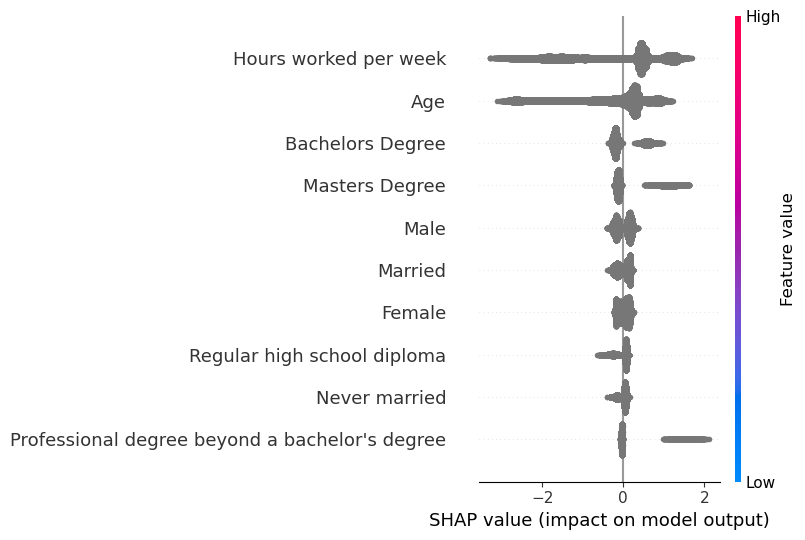

In [ ]:
mean_abs_shap_income = np.abs(shap_values_income.values).mean(axis=0)

top_20_idx = np.argsort(mean_abs_shap_income)[-20:][::-1]

original_feature_names = shap_values_income.feature_names
top_20_features = np.array(original_feature_names)[top_20_idx]

custom_names = {
    'PINCP': 'Income',
    'WKHP': 'Hours worked per week',
    'AGEP': 'Age',
    'SEX_1': 'Male',
    'SEX_2': 'Female',
    'MAR_1': 'Married', 
    'SCHL_21': 'Bachelors Degree',
    'SCHL_16':'Regular high school diploma',
    'SCHL_23':'Professional degree beyond a bachelor\'s degree',
    'DIS_1': 'With Disability',
    'SCHL_22': 'Masters Degree',
    'NATIVITY_1': 'Native',
    'MAR_5': 'Never married',
}


renamed_features = [
    custom_names.get(name, name)
    for name in original_feature_names
]
shap_values_income.feature_names = renamed_features

In [ ]:
shap.summary_plot(shap_values_income, X_test_income, max_display=10)

### Health care classifier

In [114]:
params_health = {'colsample_bytree': np.float64(0.7248770666848828), 'gamma': np.float64(1.9757511800090721), 'learning_rate': np.float64(0.28799765973813823), 'max_depth': 10, 'n_estimators': 561, 'reg_alpha': np.float64(0.1959828624191452), 'reg_lambda': np.float64(0.045227288910538066), 'subsample': np.float64(0.6626651653816322)}

best_model_health = XGBClassifier(
    eval_metric='logloss',
    n_jobs=-1,
    **params_health
)
best_model_health.fit(X_train_health, y_train_health)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.7248770666848828), device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=np.float64(1.9757511800090721), grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=np.float64(0.28799765973813823), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=561, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

In [118]:
health_explainer = shap.Explainer(best_model_health, feature_names = all_feature_names_health)
shap_values_health = health_explainer(X_test_health)

In [119]:
mean_abs_shap_health = np.abs(shap_values_health.values).mean(axis=0)

top_20_idx = np.argsort(mean_abs_shap_health)[-20:][::-1]

original_feature_names = shap_values_health.feature_names
top_20_features = np.array(original_feature_names)[top_20_idx]

custom_names = {
    'PINCP': 'Income',
    'WKHP': 'Hours worked per week',
    'AGEP': 'Age',
    'SEX_1': 'Male',
    'SEX_2': 'Female',
    'MAR_1': 'Married', 
    'SCHL_21': 'Bachelors Degree',
    'SCHL_16':'Regular high school diploma',
    'SCHL_23':'Professional degree beyond a bachelor\'s degree',
    'DIS_1': 'With Disability',
    'SCHL_22': 'Masters Degree',
    'NATIVITY_1': 'Native',
    'MAR_5': 'Never married',
    'ENG_0': 'Speaks only English',
    'NAICSP_23': 'Industry: Construction',
}


renamed_features = [
    custom_names.get(name, name)
    for name in original_feature_names
]
shap_values_health.feature_names = renamed_features

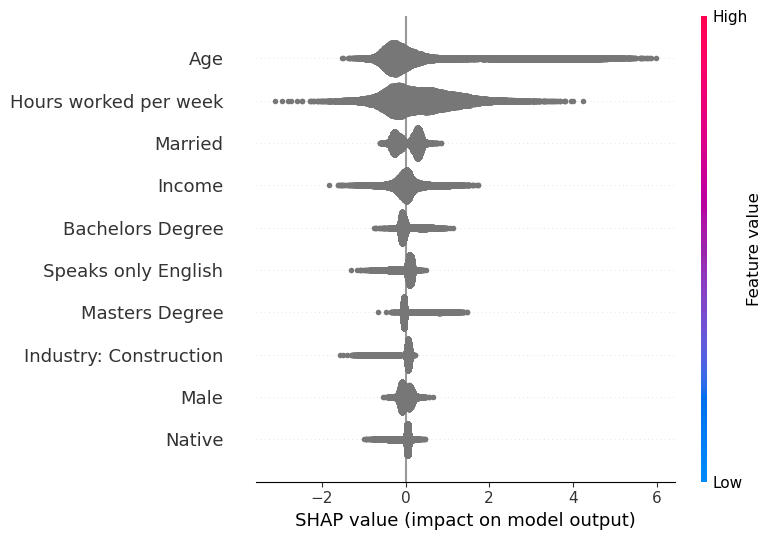

In [120]:
shap.summary_plot(shap_values_health, X_test_health, max_display=10)

## Simple FFNN

In [121]:
def build_ffnn(input_dim, hidden_units=64, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))   # Input layer, preferred way
    model.add(Dense(hidden_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(hidden_units // 2, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification output

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['AUC']
    )
    return model

def train_ffnn_for_task(X_train, y_train, X_val, y_val, input_dim, n_iter=10, random_state=42):
    np.random.seed(random_state)

    param_dist = {
        'hidden_units': [32, 64, 128],
        'dropout_rate': [0.2, 0.3, 0.4],
        'learning_rate': [1e-2, 1e-3, 1e-4],
        'batch_size': [32, 64],
        'epochs': [10, 20]
    }

    def sample_params(param_dist):
        return {k: np.random.choice(v) for k, v in param_dist.items()}

    cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = dict(zip(np.unique(y_train), cw))

    results = []

    for i in range(n_iter):
        params = sample_params(param_dist)
        print(f"Trial {i+1}/{n_iter} with params: {params}")

        model = build_ffnn(
            input_dim=input_dim,
            hidden_units=params['hidden_units'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate']
        )

        model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=params['epochs'],
            batch_size=params['batch_size'],
            verbose=0,
            class_weight=class_weights
        )

        val_preds = model.predict(X_val).ravel()
        val_auc = roc_auc_score(y_val, val_preds)
        print(f"Val AUC: {val_auc:.4f}\n")

        results.append((params, val_auc))

    best_params, best_val_auc = max(results, key=lambda x: x[1])
    print(f" Best Params: {best_params}\n Best Val AUC: {best_val_auc:.4f}")

    # Train best model on full data (optionally)
    best_model = build_ffnn(
        input_dim=input_dim,
        hidden_units=best_params['hidden_units'],
        dropout_rate=best_params['dropout_rate'],
        learning_rate=best_params['learning_rate']
    )

    best_model.fit(
        X_train, y_train,
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        verbose=0,
        class_weight=class_weights
    )

    return best_model, best_params, best_val_auc


In [122]:
input_dim_income = X_train_income.shape[1]
print("\n=== Training for Task: Income ===")
ffnn_model_income, params_income, auc_income = train_ffnn_for_task(
    X_train_income, y_train_income, X_val_income, y_val_income, input_dim_income
)

input_dim_health = X_train_health.shape[1]
print("\n=== Training for Task: Insurance ===")
ffnn_model_health, params_health, auc_health = train_ffnn_for_task(
    X_train_health, y_train_health, X_val_health, y_val_health, input_dim_health
)



=== Training for Task: Income ===
Trial 1/10 with params: {'hidden_units': np.int64(128), 'dropout_rate': np.float64(0.2), 'learning_rate': np.float64(0.0001), 'batch_size': np.int64(32), 'epochs': np.int64(20)}
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Val AUC: 0.8816

Trial 2/10 with params: {'hidden_units': np.int64(32), 'dropout_rate': np.float64(0.2), 'learning_rate': np.float64(0.0001), 'batch_size': np.int64(64), 'epochs': np.int64(10)}
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Val AUC: 0.8773

Trial 3/10 with params: {'hidden_units': np.int64(128), 'dropout_rate': np.float64(0.4), 'learning_rate': np.float64(0.0001), 'batch_size': np.int64(64), 'epochs': np.int64(10)}
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 2s 982us/step
Val AUC: 0.8784

Trial 4/10 with params: {'hidden_units': np.int64(128), 'dropout_rate': np.float64(0.3), 'learning_rate': np.float64(0.01), 'batch_size': np.int64(64), 'epochs': np.int64(20)}
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Val AUC: 0.8747

Trial 5/10 wit

In [ ]:
# income
best_params = {'hidden_units': np.int64(128), 'dropout_rate': np.float64(0.2), 'learning_rate': np.float64(0.0001), 'batch_size': np.int64(32), 'epochs': np.int64(20)}
 #Best Val AUC: 0.8816

In [123]:
# test set evluation

print("\n=== Test Performance: Income ===")
test_preds_income = ffnn_model_income.predict(X_test_income).ravel()
test_auc_income = roc_auc_score(y_test_income, test_preds_income)
print(f"Test AUC: {test_auc_income:.4f}")
print(classification_report(y_test_income, test_preds_income > 0.5))

print("\n=== Test Performance: Insurance ===")
test_preds_health = ffnn_model_health.predict(X_test_health).ravel()
test_auc_health = roc_auc_score(y_test_health, test_preds_health)
print(f"Test AUC: {test_auc_health:.4f}")
print(classification_report(y_test_health, test_preds_health > 0.5))



=== Test Performance: Income ===
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
Test AUC: 0.8808
              precision    recall  f1-score   support

           0       0.85      0.80      0.82     44346
           1       0.73      0.79      0.76     30654

    accuracy                           0.80     75000
   macro avg       0.79      0.80      0.79     75000
weighted avg       0.80      0.80      0.80     75000


=== Test Performance: Insurance ===
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
Test AUC: 0.7635
              precision    recall  f1-score   support

           0       0.18      0.70      0.29      6655
           1       0.96      0.70      0.81     68345

    accuracy                           0.70     75000
   macro avg       0.57      0.70      0.55     75000
weighted avg       0.89      0.70      0.76     75000



## DeepSHAP

### Income

c:\Users\odiee\anaconda3\envs\hcml\lib\site-packages\shap\explainers\_deep\deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
c:\Users\odiee\anaconda3\envs\hcml\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor_110. Received: the structure of inputs=['*']
  warnings.warn(
C:\Users\odiee\AppData\Local\Temp\ipykernel_10652\3409130064.py:24: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(deep_shap_values_income, X_test_sample, feature_names=all_feature_names_income, max_display=20)


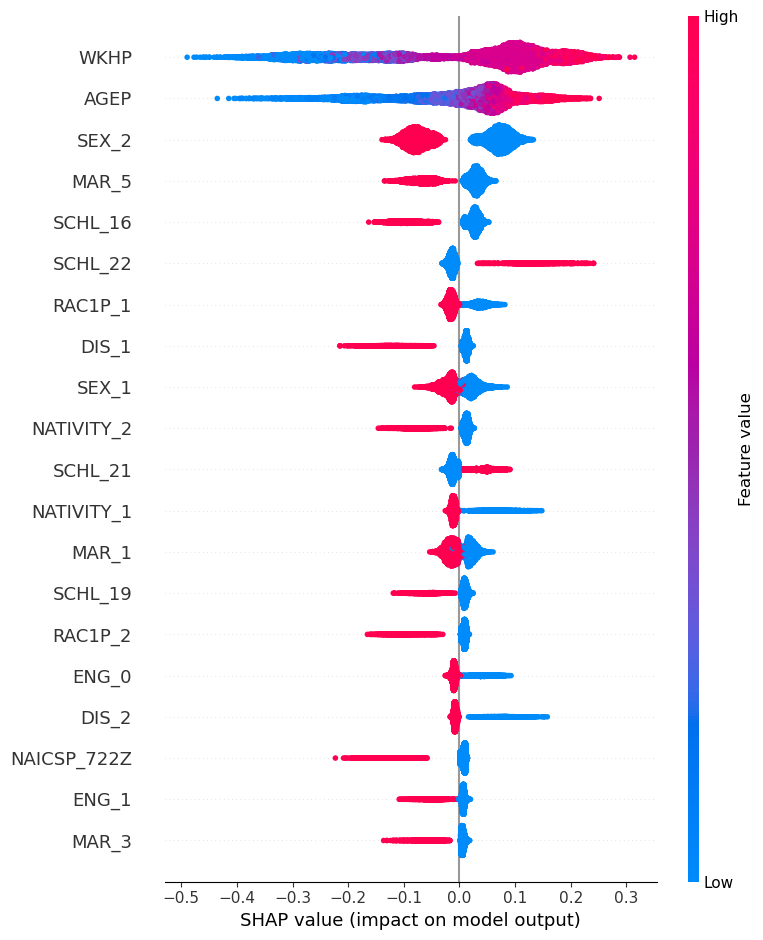

In [ ]:
# sample representative background set and sample size
background_size = 5000
test_sample_size = 10000
 
# stratified sample from training set
sss_train = StratifiedShuffleSplit(n_splits=1, test_size=background_size, random_state=42)
_ , background_idx = next(sss_train.split(X_train_income, y_train_income))
 
# stratified sample from test set
X_test_array = X_test_income.toarray() if hasattr(X_test_income, "toarray") else X_test_income
sss_test = StratifiedShuffleSplit(n_splits=1, test_size=test_sample_size, random_state=42)
_, test_sample_idx = next(sss_test.split(X_test_array, y_test_income))
X_test_sample = X_test_array[test_sample_idx]
 
# set background
background = X_train_income[background_idx]
background = background.toarray() if hasattr(background, "toarray") else background
 
# DeepSHAP
explainer_income_NN = shap.DeepExplainer(ffnn_model_income, background)
deep_shap_values_income = explainer_income_NN.shap_values(X_test_sample).squeeze(-1)

np.save('deep_shap_values.csv', deep_shap_values_income)
shap.summary_plot(deep_shap_values_income, X_test_sample, feature_names=all_feature_names_income, max_display=20)


### Health insurance

c:\Users\odiee\anaconda3\envs\hcml\lib\site-packages\shap\explainers\_deep\deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
c:\Users\odiee\anaconda3\envs\hcml\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor_231. Received: the structure of inputs=['*']
  warnings.warn(
C:\Users\odiee\AppData\Local\Temp\ipykernel_10652\3497183842.py:24: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(deep_shap_values_health, X_test_sample, feature_names=all_feature_names_health, max_display=20)


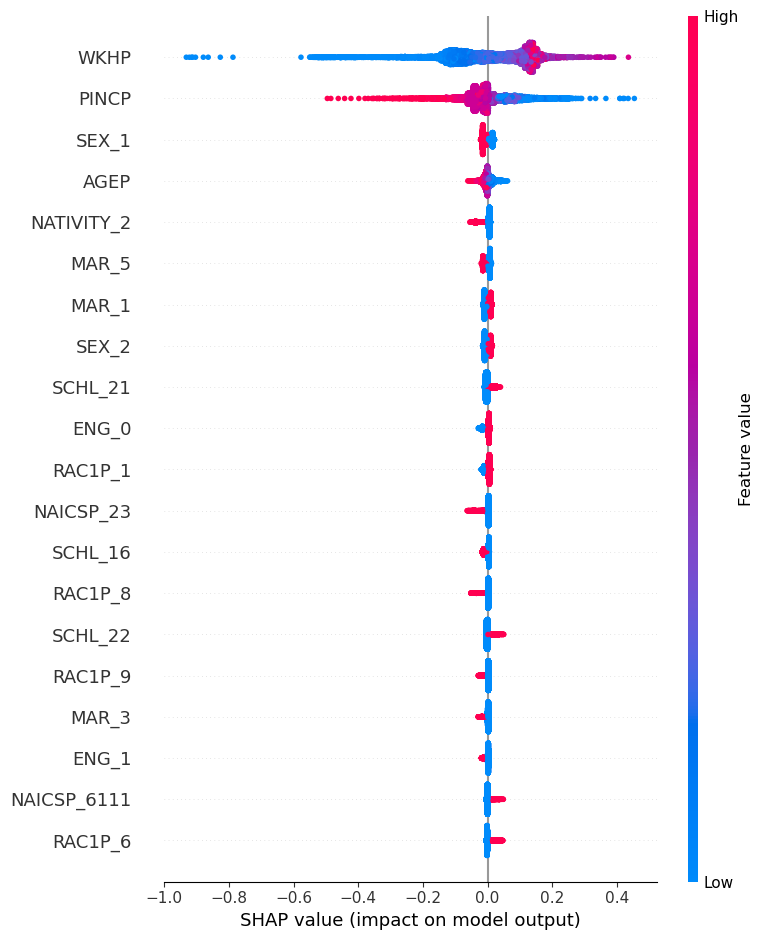

In [130]:
# sample representative background set and sample size
background_size = 5000
test_sample_size = 10000
 
# stratified sample from training set
sss_train = StratifiedShuffleSplit(n_splits=1, test_size=background_size, random_state=42)
_ , background_idx = next(sss_train.split(X_train_health, y_train_health))
 
# stratified sample from test set
X_test_array = X_test_health.toarray() if hasattr(X_test_health, "toarray") else X_test_health
sss_test = StratifiedShuffleSplit(n_splits=1, test_size=test_sample_size, random_state=42)
_, test_sample_idx = next(sss_test.split(X_test_array, y_test_health))
X_test_sample = X_test_array[test_sample_idx]
 
# set background
background = X_train_health[background_idx]
background = background.toarray() if hasattr(background, "toarray") else background
 
# DeepSHAP
explainer_health_NN = shap.DeepExplainer(ffnn_model_health, background)
deep_shap_values_health = explainer_health_NN.shap_values(X_test_sample).squeeze(-1)
 
np.save('deep_shap_values_health.csv', deep_shap_values_health)
shap.summary_plot(deep_shap_values_health, X_test_sample, feature_names=all_feature_names_health, max_display=20)


# Fairness evaluation

### Conditional statistical parity

In [ ]:
# should work on both single and intersectional groups
# convert y_pred, y_true to numpy arrays first

def conditional_statistical_parity(y_true, y_pred, protected_attr):
    strata = np.unique(y_true)
    groups = np.unique(protected_attr)
    diffs = []

    for label in strata:
        idx = (y_true == label)
        for g1, g2 in combinations(groups, 2):
            idx_g1 = idx & (protected_attr == g1)
            idx_g2 = idx & (protected_attr == g2)

            # if one of the groups has no samples in the current value of y_true, skip
            if np.sum(idx_g1) == 0 or np.sum(idx_g2) == 0:
                continue

            rate_g1 = np.mean(y_pred[idx_g1])
            rate_g2 = np.mean(y_pred[idx_g2])
            diffs.append(abs(rate_g1 - rate_g2))

    return np.nanmean(diffs) if diffs else np.nan


### Equalized odds (TPR & FPR)


In [ ]:
# should work on both single and intersectional groups
# convert y_pred, y_true to numpy arrays first

def equalized_odds(y_true, y_pred, protected_attr):
    groups = np.unique(protected_attr)
    tpr_diffs, fpr_diffs = [], []

    for g1, g2 in combinations(groups, 2):
        for label, name in [(1, "TPR"), (0, "FPR")]:
            idx1 = (y_true == label) & (protected_attr == g1)
            idx2 = (y_true == label) & (protected_attr == g2)

            if np.sum(idx1) == 0 or np.sum(idx2) == 0:
                continue

            rate1 = np.mean(y_pred[idx1])
            rate2 = np.mean(y_pred[idx2])
            diff = abs(rate1 - rate2)

            (tpr_diffs if label == 1 else fpr_diffs).append(diff)

    return {
        "TPR_diff": np.nanmean(tpr_diffs) if tpr_diffs else np.nan,
        "FPR_diff": np.nanmean(fpr_diffs) if fpr_diffs else np.nan
    }
